# Regression tree

The regression tree is a tree-based regression model that works similarly as the partitioning estimator. Recall that in partitioning estimates, given a partition of the feature space $\mathcal{X}=\bigcup_{i\in I} R_i$. Given such partition, let $x$ be any test point, and $R(x)$ be the partition that contains $x$, the predicted value is given by 

$$\hat{f}(x) = \sum_{i=1}^n\frac{\mathbb{1}_{x_{i}\in R(x)}}{\sum_{i'} \mathbb{1}_{x_{i'}\in R(x)}}y_i$$

In other words, the predicted value is the mean response values of the training observation in $A(x)$. The question now remains is how to find the partitions $\{R_i\}$?  <br>

Given $K$, the goal is to find partitions $R_1, R_2,..., R_K$ such that the root mean square of the data points to their corrsponding prediction is minimized

$$\min_{R_1,..., R_K} \;\sum_{i=1}^K \sum_{j\in R_i} (y_i - \hat{y_{R_i}})^2$$

Where $\hat{y_{R_i}}$ denote the mean response values of the training set in region $R_i$. This optimization is hard to solve since now we are minimizing over regions in $\mathcal{X}$. One way of course of solve the problem is to try every possible region combinations in $\mathcal{X}$. This is, however, computationally intractable. The regression tree therefore uses a greedy algorithm known as recursive binary splitting. It works as follows

1. Fix a feature $X_i$. 
2. Given cut-point $s$, this partitions the current space into two $R_1=\{X|X_j<s\}$ and $R_2=\{X|X_j\geq s\}$. 
3. Find the cut point $s$ that minimizes the interclass variance

$$\sum_{i\in R_1} (y_i-\hat{y_{R_1}})^2 + \sum_{i\in R_2} (y_i-\hat{y_{R_2}})^2$$

4. Repeat the process of $R_1$ and $R_2$. 

## Implementation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

We first implement the `Node` class. Each node contains the feature it is focusing on, the threshold value $s$, the left and right node, as well as the value if it is a leaf node. 

In [3]:
class Node:
    def __init__(self, feature, threshold, left, right, value):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

We then implement the body of the recursive binary splitting algorithm in the `growTree` method. On a high level, we continue splitting when 

1. There are more than 2 samples in a node, and
2. There are more than 2 features, and
3. The depth of the tree is smaller than the maximum depth

If these conditions are satisfied, we run the `getBestSplit` method to find the optimum feature and cut. It iterates through all possible feature and cut choices, and, for each of these combinations, computes the loss following $(2)$. The method then returns the feature and the cut $s$ that minimizes the loss, as well as the partitioned dataset. The `growTree` method is then called on the partitioned regions. 

In [20]:
class RegressionTree:
    
    def __init__(self, minSplit=2, maxDepth=10):
        self.root = None
        self.minSplit = 2
        self.maxDepth = maxDepth
        
    def fit(self, X, y):        
        self.root = self.growTree(X, y)
        
    def growTree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if len(y) == 0:
            return None
        if n_samples >= 2 and n_features >= self.minSplit and depth <= self.maxDepth:   
            feature, threshold, left_X, left_y, right_X, right_y, _ = self.getBestSplit(X, y)
            leftTree = self.growTree(left_X, left_y, depth+1)
            rightTree = self.growTree(right_X, right_y, depth+1)
            return Node(feature, threshold, leftTree, rightTree, None)
        value = self.getValue(X, y)
        return Node(None, None, None, None, value)
    
    def getBestSplit(self, X, y):
        n_samples, n_features = X.shape
        feature = None
        threshold = None
        loss = float("inf")
        for f in range(n_features):
            thresholds = np.unique(X[:, f])
            for t in thresholds:
                if self.loss(X, y, f, t) < loss:
                    feature = f
                    threshold = t
                    loss = self.loss(X, y, f, t)
        left_idx, right_idx = X[:, feature] <= threshold, X[:, feature] > threshold
        left_X, left_y = X[left_idx], y[left_idx]
        right_X, right_y = X[right_idx], y[right_idx]
        return feature, threshold, left_X, left_y, right_X, right_y, loss
    
    def loss(self, X, y, feature, threshold):
        left_y, right_y = y[X[:, feature] <= threshold], y[X[:, feature] > threshold]
        left_loss = np.sum((left_y - np.mean(left_y)) ** 2)
        right_loss = np.sum((right_y - np.mean(right_y)) ** 2)
        return left_loss + right_loss
    
    def getValue(self, X, y):
        return np.mean(y)
    
    def predict(self, X):
        return np.array([self._predict(inputs, self.root) for inputs in X])
    
    def _predict(self, inputs, tree):
        if tree.value is not None:
            return tree.value
        feature, threshold = tree.feature, tree.threshold
        if inputs[feature] <= threshold:
            return self._predict(inputs, tree.left)
        else:
            return self._predict(inputs, tree.right)

We can test our implmentation using synthetic data. Consider the data generated by 

$$Y=3X_1+2X_2+\epsilon$$

We plot the data points in three dimensions

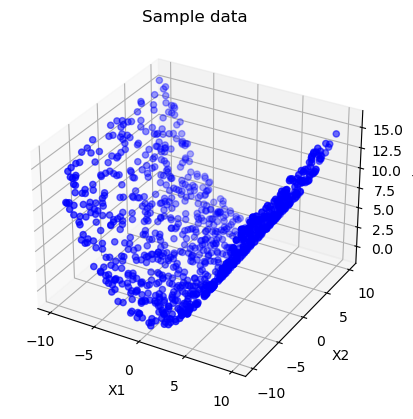

In [68]:
def generate_2d_regression_data(num_samples=100, noise=0.1):
    np.random.seed(0)
    x1 = np.random.uniform(-10, 10, num_samples)
    x2 = np.random.uniform(-10, 10, num_samples)
    y = 0.15 * x1 ** 2 + 0.1 * x2 + np.random.normal(0, noise, num_samples)
    X = np.column_stack((x1, x2))
    return X, y

X, y = generate_2d_regression_data(num_samples=1000, noise=0.01)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, c='b', marker='o')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.set_title("Sample data")
plt.show()

We now fit our regression tree on the sample data points

In [69]:
tree = RegressionTree(maxDepth=2)
tree.fit(X, y)

We can visualize the learned cuts

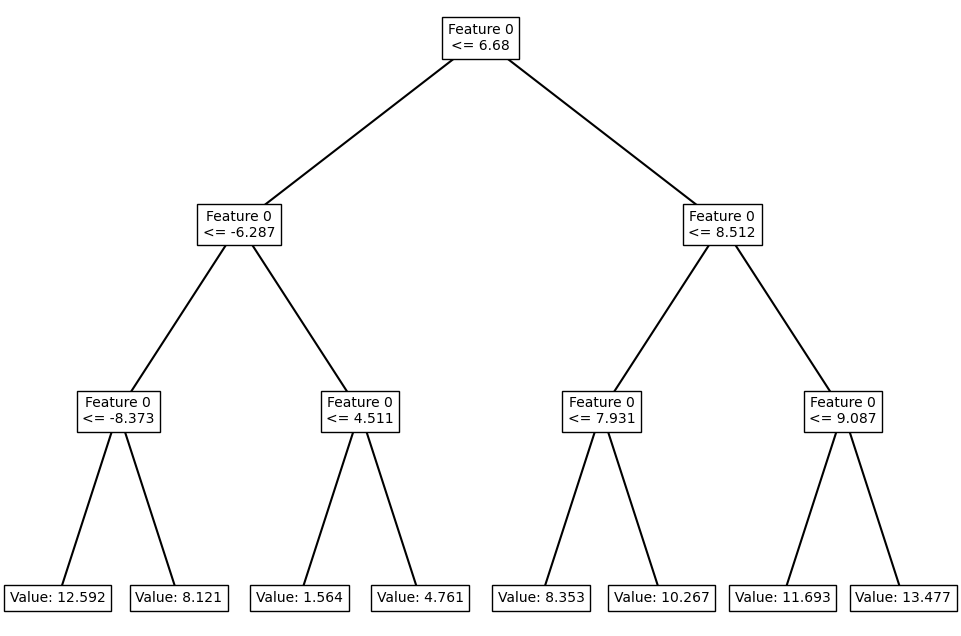

In [70]:
def plot_node(ax, node, x, y, dx, dy):
    if node is None:
        return
    if node.value is not None:
        ax.text(x, y, f"Value: {round(node.value, 3)}", ha='center', va='center', 
                bbox=dict(facecolor='white', edgecolor='black'))
    else:
        ax.text(x, y, f"Feature {node.feature}\n<= {round(node.threshold, 3)}", ha='center', va='center', 
                bbox=dict(facecolor='white', edgecolor='black'))
        if node.left:
            ax.plot([x, x - dx], [y, y - dy], 'k-')
            plot_node(ax, node.left, x - dx, y - dy, dx / 2, dy)
        if node.right:
            ax.plot([x, x + dx], [y, y - dy], 'k-')
            plot_node(ax, node.right, x + dx, y - dy, dx / 2, dy)

def plot_tree(node):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    plot_node(ax, node, x=0.5, y=1, dx=0.25, dy=0.1)
    plt.show()
    
plot_tree(tree.root)

We can also visualize how the input space is being partitioned. Note that the estimated decision surface matches the true data. 

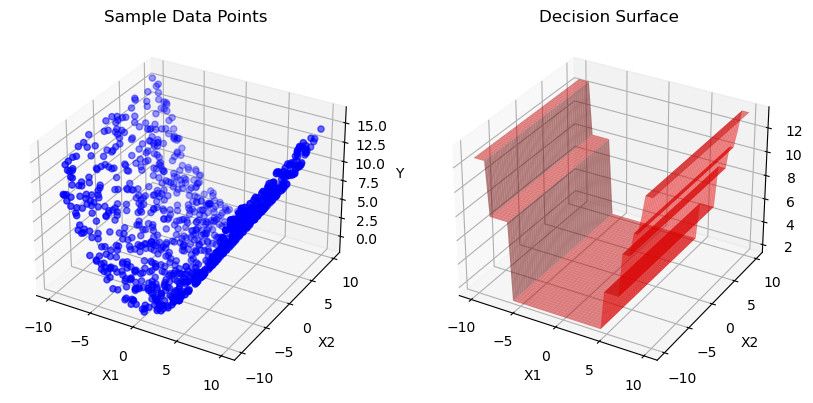

In [71]:
x1_range = np.linspace(-10, 10, 50)
x2_range = np.linspace(-10, 10, 50)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
X_grid = np.column_stack([x1_grid.ravel(), x2_grid.ravel()])
y_pred = tree.predict(X_grid).reshape(x1_grid.shape)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], y, c='b', marker='o')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Y')
ax1.set_title("Sample Data Points")
ax1.view_init(elev=30, azim=-60) 
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x1_grid, x2_grid, y_pred, color='r', alpha=0.5)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Y')
ax2.set_title("Decision Surface")
ax2.view_init(elev=30, azim=-60) 
plt.show()

We can also increase the depth of the tree to gain better performance.

In [72]:
tree = RegressionTree(maxDepth=5)
tree.fit(X, y)

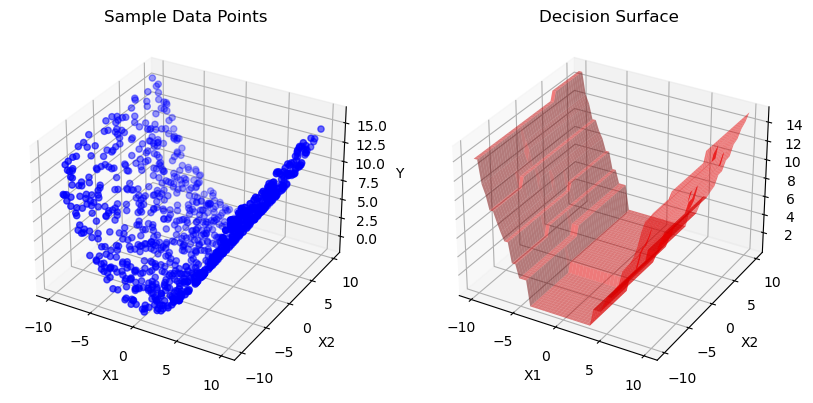

In [73]:
x1_range = np.linspace(-10, 10, 50)
x2_range = np.linspace(-10, 10, 50)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
X_grid = np.column_stack([x1_grid.ravel(), x2_grid.ravel()])
y_pred = tree.predict(X_grid).reshape(x1_grid.shape)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], y, c='b', marker='o')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Y')
ax1.set_title("Sample Data Points")
ax1.view_init(elev=30, azim=-60) 
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x1_grid, x2_grid, y_pred, color='r', alpha=0.5)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Y')
ax2.set_title("Decision Surface")
ax2.view_init(elev=30, azim=-60) 
plt.show()